In [ ]:
%matplotlib inline


============================================================
Sparse recovery: feature selection for sparse linear models
============================================================

Given a small number of observations, we want to recover which features
of X are relevant to explain y. For this :ref:`sparse linear models
<l1_feature_selection>` can outperform standard statistical tests if the
true model is sparse, i.e. if a small fraction of the features are
relevant.

As detailed in :ref:`the compressive sensing notes
<compressive_sensing>`, the ability of L1-based approach to identify the
relevant variables depends on the sparsity of the ground truth, the
number of samples, the number of features, the conditioning of the
design matrix on the signal subspace, the amount of noise, and the
absolute value of the smallest non-zero coefficient [Wainwright2006]
(http://statistics.berkeley.edu/sites/default/files/tech-reports/709.pdf).

Here we keep all parameters constant and vary the conditioning of the
design matrix. For a well-conditioned design matrix (small mutual
incoherence) we are exactly in compressive sensing conditions (i.i.d
Gaussian sensing matrix), and L1-recovery with the Lasso performs very
well. For an ill-conditioned matrix (high mutual incoherence),
regressors are very correlated, and the Lasso randomly selects one.
However, randomized-Lasso can recover the ground truth well.

In each situation, we first vary the alpha parameter setting the sparsity
of the estimated model and look at the stability scores of the randomized
Lasso. This analysis, knowing the ground truth, shows an optimal regime
in which relevant features stand out from the irrelevant ones. If alpha
is chosen too small, non-relevant variables enter the model. On the
opposite, if alpha is selected too large, the Lasso is equivalent to
stepwise regression, and thus brings no advantage over a univariate
F-test.

In a second time, we set alpha and compare the performance of different
feature selection methods, using the area under curve (AUC) of the
precision-recall.


In [31]:
print(__doc__)

# Author: Alexandre Gramfort and Gael Varoquaux
# License: BSD 3 clause

import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn.linear_model import (RandomizedLasso, lasso_stability_path,
                                  LassoLarsCV)
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils.extmath import pinvh
from sklearn.exceptions import ConvergenceWarning


def mutual_incoherence(X_relevant, X_irelevant):
    """Mutual incoherence, as defined by formula (26a) of [Wainwright2006].
    """
    projector = np.dot(np.dot(X_irelevant.T, X_relevant),
                       pinvh(np.dot(X_relevant.T, X_relevant)))
    return np.max(np.abs(projector).sum(axis=1))


for conditioning in (1, 1e-4):
    ###########################################################################
    # Simulate regression data with a correlated design
    n_features = 501
    n_relevant_features = 3
    noise_level = .2
    coef_min = .2
    # The Donoho-Tanner phase transition is around n_samples=25: below we
    # will completely fail to recover in the well-conditioned case
    n_samples = 25
    block_size = n_relevant_features

    rng = np.random.RandomState(42)

    # The coefficients of our model
    coef = np.zeros(n_features)
    coef[:n_relevant_features] = coef_min + rng.rand(n_relevant_features)

    # The correlation of our design: variables correlated by blocs of 3
    corr = np.zeros((n_features, n_features))
    for i in range(0, n_features, block_size):
        corr[i:i + block_size, i:i + block_size] = 1 - conditioning
    corr.flat[::n_features + 1] = 1
    corr = linalg.cholesky(corr)
    

    # Our design
    X = rng.normal(size=(n_samples, n_features))
    X = np.dot(X, corr)
    # Keep [Wainwright2006] (26c) constant
    X[:n_relevant_features] /= np.abs(
        linalg.svdvals(X[:n_relevant_features])).max()
    X = StandardScaler().fit_transform(X.copy())

    # The output variable
    y = np.dot(X, coef)
    y /= np.std(y)
    # We scale the added noise as a function of the average correlation
    # between the design and the output variable
    y += noise_level * rng.normal(size=n_samples)
    mi = mutual_incoherence(X[:, :n_relevant_features],
                            X[:, n_relevant_features:])

    ###########################################################################
    # Plot stability selection path, using a high eps for early stopping
    # of the path, to save computation time
    alpha_grid, scores_path = lasso_stability_path(X, y, random_state=42,
                                                   eps=0.05)

    plt.figure()
    # We plot the path as a function of alpha/alpha_max to the power 1/3: the
    # power 1/3 scales the path less brutally than the log, and enables to
    # see the progression along the path
    hg = plt.plot(alpha_grid[1:] ** .333, scores_path[coef != 0].T[1:], 'r')
    hb = plt.plot(alpha_grid[1:] ** .333, scores_path[coef == 0].T[1:], 'k')
    ymin, ymax = plt.ylim()
    plt.xlabel(r'$(\alpha / \alpha_{max})^{1/3}$')
    plt.ylabel('Stability score: proportion of times selected')
    plt.title('Stability Scores Path - Mutual incoherence: %.1f' % mi)
    plt.axis('tight')
    plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
               loc='best')

    ###########################################################################
    # Plot the estimated stability scores for a given alpha

    # Use 6-fold cross-validation rather than the default 3-fold: it leads to
    # a better choice of alpha:
    # Stop the user warnings outputs- they are not necessary for the example
    # as it is specifically set up to be challenging.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        lars_cv = LassoLarsCV(cv=6).fit(X, y)

    # Run the RandomizedLasso: we use a paths going down to .1*alpha_max
    # to avoid exploring the regime in which very noisy variables enter
    # the model
    alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6)
    clf = RandomizedLasso(alpha=alphas, random_state=42).fit(X, y)
    trees = ExtraTreesRegressor(100).fit(X, y)
    # Compare with F-score
    F, _ = f_regression(X, y)

    plt.figure()
    for name, score in [('F-test', F),
                        ('Stability selection', clf.scores_),
                        ('Lasso coefs', np.abs(lars_cv.coef_)),
                        ('Trees', trees.feature_importances_),
                        ]:
        precision, recall, thresholds = precision_recall_curve(coef != 0,
                                                               score)
        plt.semilogy(np.maximum(score / np.max(score), 1e-4),
                     label="%s. AUC: %.3f" % (name, auc(recall, precision)))

    plt.plot(np.where(coef != 0)[0], [2e-4] * n_relevant_features, 'mo',
             label="Ground truth")
    plt.xlabel("Features")
    plt.ylabel("Score")
    # Plot only the 100 first coefficients
    plt.xlim(0, 100)
    plt.legend(loc='best')
    plt.title('Feature selection scores - Mutual incoherence: %.1f'
              % mi)

plt.show()

Automatically created module for IPython interactive environment


ValueError: Found input variables with inconsistent numbers of samples: [25, 501]

(25, 501)
(25, 501)
(501, 501)
[[-0.04713538  0.01351906  0.01182926 ..., -0.01532162 -0.01011033
  -0.01942043]
 [-0.02653741 -0.01619013 -0.01752723 ...,  0.05584272  0.01701396
   0.09252194]
 [-0.01566495  0.00867136 -0.0437311  ..., -0.0183049  -0.03756156
  -0.03574793]]
[[ 0.08055754  0.30255293  0.18438936 ...,  0.21847517  0.35318162
  -0.14648887]
 [ 0.11041436  0.27192247  0.15153689 ...,  0.31400527  0.37813214
  -0.04215274]
 [ 0.12617402  0.29755491  0.12221249 ...,  0.21447045  0.32793036
  -0.16170696]
 ..., 
 [ 0.47869871 -1.20084294 -0.3932265  ..., -0.11475087 -0.31150516
   0.15674549]
 [-0.11672806  0.54806892  1.41467231 ...,  0.01635051 -0.73684954
   0.51681111]
 [-0.17254972 -1.41037269 -0.43948846 ..., -0.64631244  0.66831034
   1.1181593 ]]
[ 0.57454012  1.15071431  0.93199394  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.    

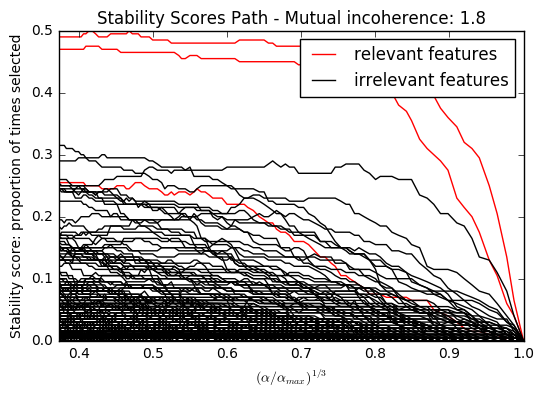

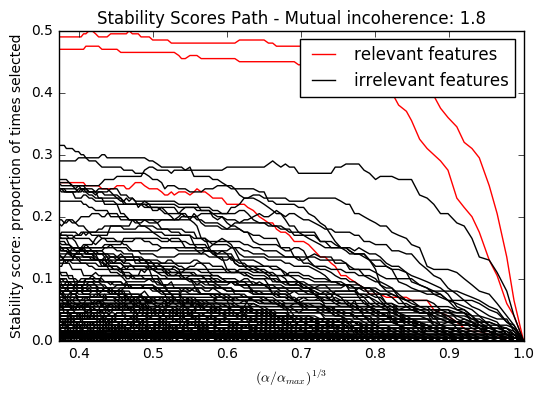

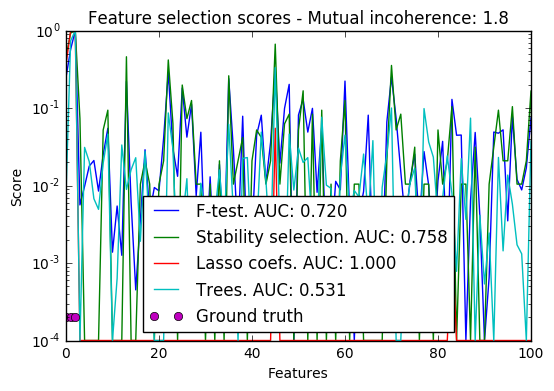

In [37]:

n_features = 501
n_relevant_features = 3
noise_level = .2
coef_min = .2
# The Donoho-Tanner phase transition is around n_samples=25: below we
# will completely fail to recover in the well-conditioned case
n_samples = 25
block_size = n_relevant_features

rng = np.random.RandomState(42)

# The coefficients of our model
coef = np.zeros(n_features)
coef[:n_relevant_features] = coef_min + rng.rand(n_relevant_features)

# The correlation of our design: variables correlated by blocs of 3
corr = np.zeros((n_features, n_features))
for i in range(0, n_features, block_size):
	corr[i:i + block_size, i:i + block_size] = 1 - conditioning
corr.flat[::n_features + 1] = 1
corr = linalg.cholesky(corr)
# Our design
X = rng.normal(size=(n_samples, n_features))
print X.shape
X = np.dot(X, corr)
print X.shape
print corr.shape

# Keep [Wainwright2006] (26c) constant
X[:n_relevant_features] /= np.abs(
	linalg.svdvals(X[:n_relevant_features])).max()
print X[:n_relevant_features]
X = StandardScaler().fit_transform(X.copy())
print X
# The output variable
y = np.dot(X, coef)
print coef
print y.shape
y /= np.std(y)
# We scale the added noise as a function of the average correlation
# between the design and the output variable
y += noise_level * rng.normal(size=n_samples)
mi = mutual_incoherence(X[:, :n_relevant_features],
						X[:, n_relevant_features:])


###########################################################################
# Plot stability selection path, using a high eps for early stopping
# of the path, to save computation time
alpha_grid, scores_path = lasso_stability_path(X, y, random_state=42,
											   eps=0.05)

plt.figure()
# We plot the path as a function of alpha/alpha_max to the power 1/3: the
# power 1/3 scales the path less brutally than the log, and enables to
# see the progression along the path
hg = plt.plot(alpha_grid[1:] ** .333, scores_path[coef != 0].T[1:], 'r')
hb = plt.plot(alpha_grid[1:] ** .333, scores_path[coef == 0].T[1:], 'k')
ymin, ymax = plt.ylim()
plt.xlabel(r'$(\alpha / \alpha_{max})^{1/3}$')
plt.ylabel('Stability score: proportion of times selected')
plt.title('Stability Scores Path - Mutual incoherence: %.1f' % mi)
plt.axis('tight')
plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
		   loc='best')

###########################################################################
# Plot the estimated stability scores for a given alpha

# Use 6-fold cross-validation rather than the default 3-fold: it leads to
# a better choice of alpha:
# Stop the user warnings outputs- they are not necessary for the example
# as it is specifically set up to be challenging.
with warnings.catch_warnings():
	warnings.simplefilter('ignore', UserWarning)
	warnings.simplefilter('ignore', ConvergenceWarning)
	lars_cv = LassoLarsCV(cv=6).fit(X, y)

# Run the RandomizedLasso: we use a paths going down to .1*alpha_max
# to avoid exploring the regime in which very noisy variables enter
# the model
alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6)
clf = RandomizedLasso(alpha=alphas, random_state=42).fit(X, y)
trees = ExtraTreesRegressor(100).fit(X, y)
# Compare with F-score
F, _ = f_regression(X, y)

plt.figure()
for name, score in [('F-test', F),
					('Stability selection', clf.scores_),
					('Lasso coefs', np.abs(lars_cv.coef_)),
					('Trees', trees.feature_importances_),
					]:
	precision, recall, thresholds = precision_recall_curve(coef != 0,
														   score)
	plt.semilogy(np.maximum(score / np.max(score), 1e-4),
				 label="%s. AUC: %.3f" % (name, auc(recall, precision)))

plt.plot(np.where(coef != 0)[0], [2e-4] * n_relevant_features, 'mo',
		 label="Ground truth")
plt.xlabel("Features")
plt.ylabel("Score")
# Plot only the 100 first coefficients
plt.xlim(0, 100)
plt.legend(loc='best')
plt.title('Feature selection scores - Mutual incoherence: %.1f'
		  % mi)
print coef

plt.show()